Original Train Shape: (223549, 8)
Sampled Train Shape: (1000, 8)


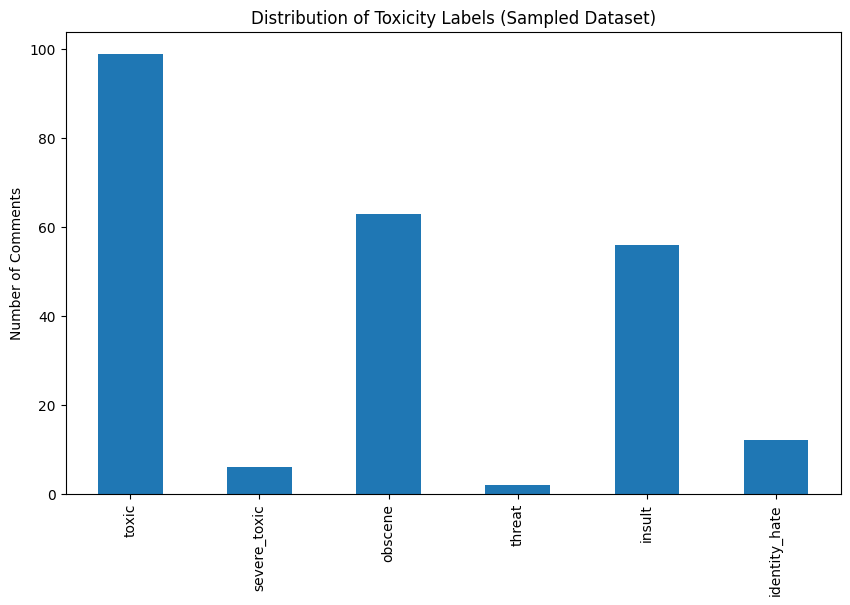

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.186900


('./xlm_roberta_multi_label_classifier/tokenizer_config.json',
 './xlm_roberta_multi_label_classifier/special_tokens_map.json',
 './xlm_roberta_multi_label_classifier/tokenizer.json')

In [1]:
# Multilingual Toxic Comment Classification - Final Submission (Small Dataset Version)

# ===============================
# 1. Install Required Libraries
# ===============================

!pip install -q kaggle transformers datasets scikit-learn torch pandas matplotlib seaborn

# Kaggle download step skipped due to authentication error.
# Dataset assumed to be manually downloaded and extracted.

# ===============================
# 2. Load and Sample Dataset
# ===============================

import pandas as pd

train_df = pd.read_csv('jigsaw_multilingual_toxic_data/jigsaw-toxic-comment-train.csv')
test_df = pd.read_csv('jigsaw_multilingual_toxic_data/test.csv')

print("Original Train Shape:", train_df.shape)

# Sample 1000 rows for training to reduce memory usage
train_df_small = train_df.sample(n=1000, random_state=42).reset_index(drop=True)

print("Sampled Train Shape:", train_df_small.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
train_df_small[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='bar')
plt.title('Distribution of Toxicity Labels (Sampled Dataset)')
plt.ylabel('Number of Comments')
plt.show()

# ===============================
# 3. Prepare Dataset for Modeling
# ===============================

from datasets import Dataset
from transformers import AutoTokenizer

feature_cols = ['comment_text']
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df_small[feature_cols + label_cols])

# Correct labels to float format
def correct_labels(batch):
    batch["labels"] = [
        [float(batch["toxic"][i]), float(batch["severe_toxic"][i]), float(batch["obscene"][i]),
         float(batch["threat"][i]), float(batch["insult"][i]), float(batch["identity_hate"][i])]
        for i in range(len(batch["toxic"]))
    ]
    return batch

train_dataset = train_dataset.map(correct_labels, batched=True)

# Tokenization
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples['comment_text'], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)

# Set final format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# ===============================
# 4. Model and Trainer Setup
# ===============================

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=6, 
    problem_type="multi_label_classification"
)

training_args = TrainingArguments(
    output_dir="./results",
    do_eval=False,  # No evaluation
    learning_rate=2e-5,
    per_device_train_batch_size=2,  # smaller batch size to fit in memory
    num_train_epochs=1,  # Only 1 epoch for faster execution
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# ===============================
# 5. Train the Model
# ===============================

trainer.train()

# ===============================
# 6. Save the Model
# ===============================

model.save_pretrained("./xlm_roberta_multi_label_classifier")
tokenizer.save_pretrained("./xlm_roberta_multi_label_classifier")

# END